In [5]:
from ase.io import read 

atoms_list = read('../data/gen_7-2025-02-12.xyz', index=':')

In [11]:
print(atoms_list[0].info)

{'generation': 7, 'source_path': 'V-Cr-Ti-W-Zr/Fixed_Engrads/vcrtiwzr_fin_engrads/job_gen_7-2025-02-12/Cr/Cr117_tri-vacancy_idx_3427', 'date_processed': '2025-02-12T16:43:40.980844', 'REF_stress': array([-0.00151252, -0.00030062, -0.00146684, -0.00030062, -0.0046191 ,
        0.00142216, -0.00146684,  0.00142216, -0.0019116 ]), 'REF_energy': -1094.8750554}


In [15]:
for i in [101, 102, 103, 104]:
    print(f"Atoms {i}: {atoms_list[i].info}")


Atoms 101: {'generation': 7, 'structure_index': 3507, 'composition': 'Cr12', 'config_type': 'surface_100', 'source_path': 'V-Cr-Ti-W-Zr/Fixed_Engrads/vcrtiwzr_fin_engrads/job_gen_7-2025-02-12/Cr/Cr12_surface_100_idx_3507', 'date_processed': '2025-02-12T16:43:50.422887', 'REF_energy': -1748976.37883896}
Atoms 102: {'generation': 7, 'structure_index': 3517, 'composition': 'Cr12', 'config_type': 'surface_100', 'source_path': 'V-Cr-Ti-W-Zr/Fixed_Engrads/vcrtiwzr_fin_engrads/job_gen_7-2025-02-12/Cr/Cr12_surface_100_idx_3517', 'date_processed': '2025-02-12T16:43:50.512203', 'REF_energy': -475462.9788244}
Atoms 103: {'generation': 7, 'structure_index': 3522, 'composition': 'Cr12', 'config_type': 'surface_100', 'source_path': 'V-Cr-Ti-W-Zr/Fixed_Engrads/vcrtiwzr_fin_engrads/job_gen_7-2025-02-12/Cr/Cr12_surface_100_idx_3522', 'date_processed': '2025-02-12T16:43:50.594143', 'REF_energy': -4458159.90466086}
Atoms 104: {'generation': 7, 'structure_index': 3527, 'composition': 'Cr12', 'config_type'

In [16]:
from ase.io import write
write('cr_100_surfaces.xyz', atoms_list[100:104])

In [12]:
data_list = []
for atoms in atoms_list:
    data = {}
    try:
        data['energy'] = atoms.info['REF_energy']
        data['elements'] = atoms.get_chemical_symbols()
        data['positions'] = atoms.get_positions()
        data['forces'] = atoms.arrays['REF_force']
        data['stress'] = atoms.info['REF_stress']
        data['info'] = atoms.info
    except KeyError:
        print(f"KeyError for atoms with index {atoms_list.index(atoms)}")
        continue
    data_list.append(data)

print(len(data_list))


KeyError for atoms with index 101
KeyError for atoms with index 102
KeyError for atoms with index 103
KeyError for atoms with index 104
22197


Energy statistics (eV):
  Min: -3226.26
  Max: 91.30
  Mean: -1012.24
  Std: 301.21
  Range: 3317.56


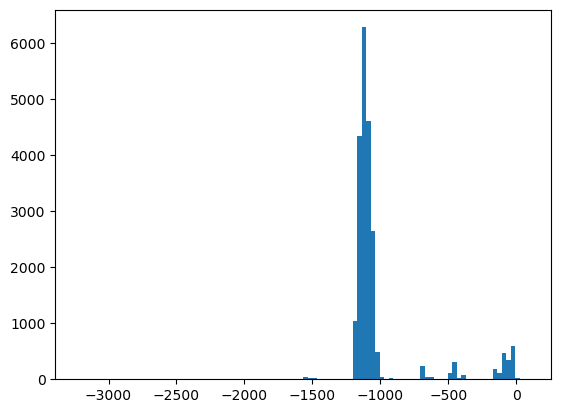

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_energy_distribution(data_list):
    energies = [data['energy'] for data in data_list]
    e_min = np.min(energies)
    e_max = np.max(energies)
    e_mean = np.mean(energies)
    e_std = np.std(energies)
    e_range = e_max - e_min

    print(f"Energy statistics (eV):")
    print(f"  Min: {e_min:.2f}")
    print(f"  Max: {e_max:.2f}")
    print(f"  Mean: {e_mean:.2f}")
    print(f"  Std: {e_std:.2f}")
    print(f"  Range: {e_range:.2f}")
    plt.hist(energies, bins=100)
    plt.show()

analyze_energy_distribution(data_list)

In [18]:
def calculate_Q_shifted(data_list, temperature):
    """Calculate partition function with energy shift approach"""
    energies = [data['energy'] for data in data_list]
    k_B = 8.617e-5  # eV/K
    e_min = np.min(energies)
    
    # Shift energies by subtracting minimum
    shifted_energies = energies - e_min
    
    # Calculate Q using shifted energies
    exp_terms = np.exp(-shifted_energies / (k_B * temperature))
    Q = np.sum(exp_terms)
    
    return Q, shifted_energies

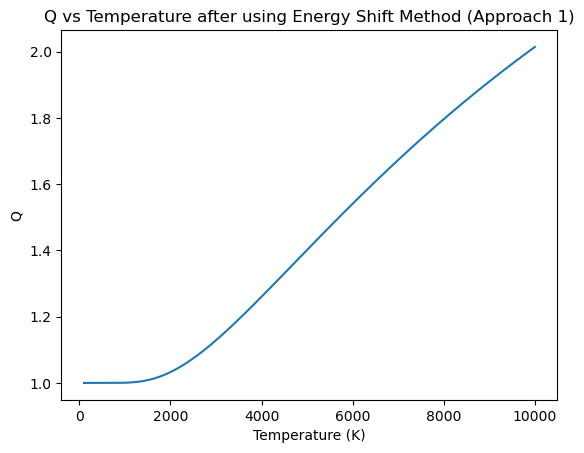

In [25]:
temps = np.linspace(100, 10000, 1000)
Q_list_1 = []
for temp in temps:
    Q, shifted_energies = calculate_Q_shifted(data_list, temp)
    Q_list_1.append(Q)

plt.title("Q vs Temperature after using Energy Shift Method (Approach 1)")
plt.xlabel("Temperature (K)")
plt.ylabel("Q")
plt.plot(temps, Q_list_1)
plt.show()

In [30]:
def calculate_log_probabilities(data_list, temperature):
    """Calculate log probabilities using the log-sum-exp trick"""
    energies = np.array([data['energy'] for data in data_list])  # Convert energies to numpy array
    k_B = 8.617e-5  # eV/K
    kT = k_B * temperature
    
    # Calculate log(exp(-E/kT))
    log_exp_terms = -energies / kT
    
    # Find maximum for numerical stability
    c = np.max(log_exp_terms)
    
    # Calculate log(Q) using the log-sum-exp trick
    log_Q = c + np.log(np.sum(np.exp(log_exp_terms - c)))
    
    # Calculate log probabilities
    log_probs = log_exp_terms - log_Q
    
    return log_probs, log_Q

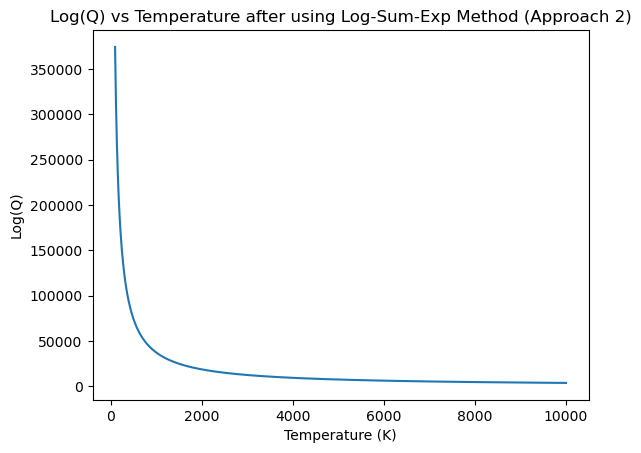

In [31]:
temps = np.linspace(100, 10000, 1000)
Q_list_2 = []
for temp in temps:
    log_probs, log_Q = calculate_log_probabilities(data_list, temp)
    Q_list_2.append(log_Q)

plt.title("Log(Q) vs Temperature after using Log-Sum-Exp Method (Approach 2)")
plt.xlabel("Temperature (K)")
plt.ylabel("Log(Q)")
plt.plot(temps, np.array(Q_list_2))  # Convert Q_list_2 to numpy array before plotting
plt.show()

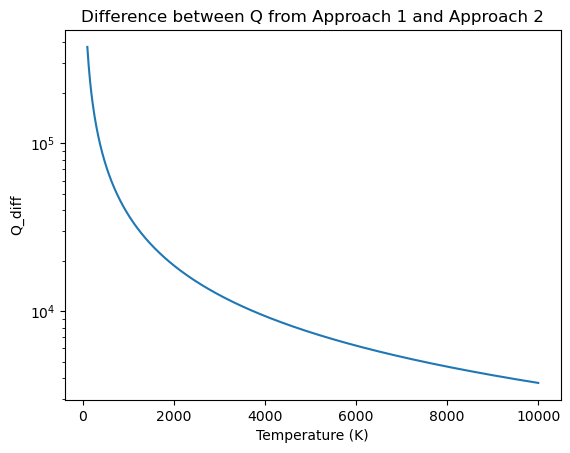

In [34]:
Q_diff = np.array(Q_list_2) - np.array(Q_list_1)
plt.title("Difference between Q from Approach 1 and Approach 2")
plt.xlabel("Temperature (K)")
plt.ylabel("Q_diff")
plt.plot(temps, Q_diff)
plt.yscale('log')
plt.show()